# physics760 - Problem Set 5

### Team:
- Sumin Alff-Kim : 3282322
- Lennart Voorgang: 3124372

### Code
- [Repository](https://github.com/lennartvrg/ComputationalPhysics)
- [Subdirectory for this assignment](https://github.com/lennartvrg/ComputationalPhysics/tree/main/5%20-%20The%20Ising%20Model%20in%202D)
- CommitID: **8d41270de0744873c66374e5baa6287e0870f302**

### Dependencies
- CMake 3.25+
- Thread building-blocks library. **ubuntu**: `sudo apt-get install libtbb-dev`. **macOS**: `brew install tbb`.
- `c++23` comptabile compiler **macOS**: As the Apple version of clang does not support parallel algorithms, one must install `gcc` via homebrew: `brew install gcc`.

### Run the `c++` code
- `mkdir build && cd build`
- `cmake .. && make ising_2d -j 4 && cp main ../5\ -\ The\ Ising\ Model\ in\ 2D/`
- `cd ../5\ -\ The\ Ising\ Model\ in\ 2D/ && ./ising_2d`
- You should now have an output directory with several `CSV` files within it

### Run the `python` code
- Create the environment with `python3 -m venv .venv`
- To active the environment run `source .venv/bin/active` (Linux)
- To Install the required dependencies run `pip install -r requirements.txt`
- Run `jupyter notebook`

In [1]:
# Standard imports for computational physics
from typing import Tuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots

# Pretty styling for graphs
plt.style.use(['science', 'grid', 'scatter', 'notebook'])
plt.rcParams["figure.figsize"] = (12, 8)

# The Ising Model in 2D

In [2]:
LATTICE_LENGTHS = np.array([4, 8, 12])

Critical = np.log(1 + np.sqrt(2)) / 2.0

## 5.1 Exact Results

<font color='blue'> **Q. Implement the exactly-known $\langle |m| \rangle$ and $\epsilon$. Don’t implement the elliptic $K$ yourself unless you imagine enjoying it.**</font>

Both functions are implemented in `src/main.cpp`.

<font color='blue'> **Q. It is standard to plot as a function of $1/J$ (because $1/(\beta J) ~ T$). Make $2$ plots, one for each observable, plotting them against $1/J \in [0.1, 5]$ with fine steps.**</font>

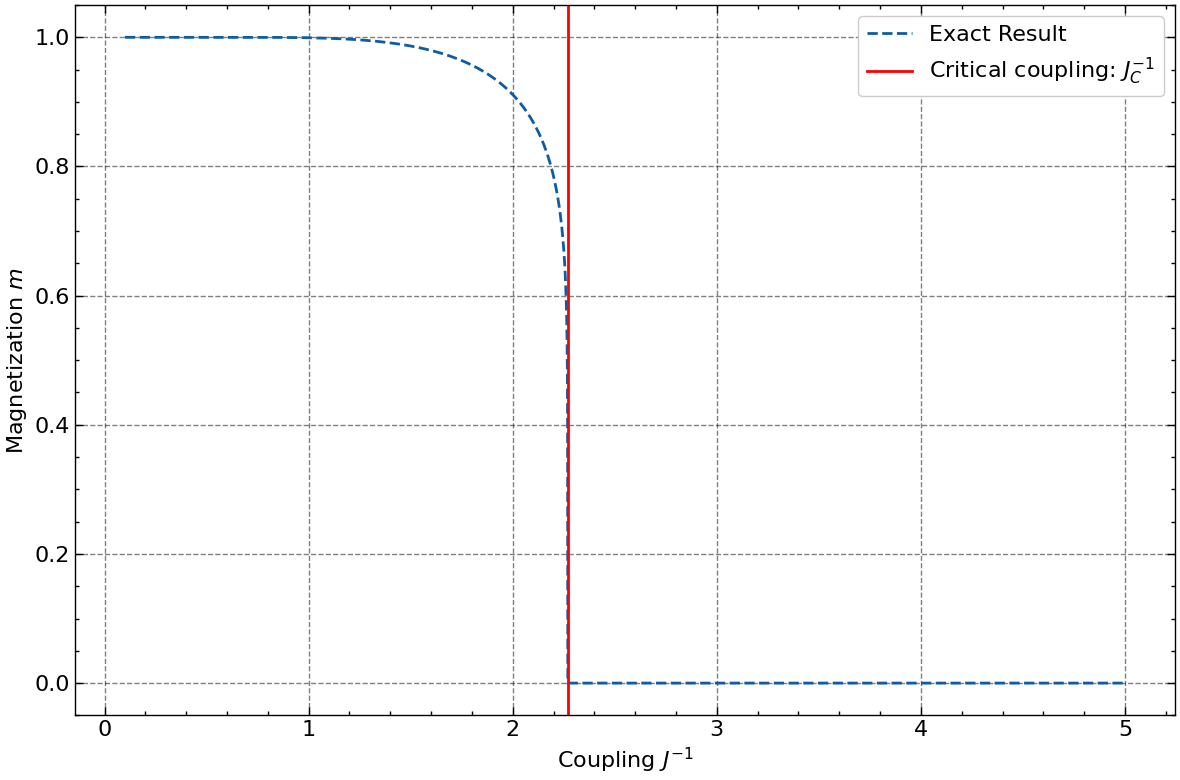

In [3]:
data = pd.read_csv('output/exact_results.csv')

fig, ax = plt.subplots()
ax.plot(1.0 / data['j'], data['magnetization'], '--', label='Exact Result')
ax.axvline(1.0 / Critical, color='red', label='Critical coupling: $J_C^{-1}$')

ax.set_xlabel('Coupling $J^{-1}$')
ax.set_ylabel('Magnetization $m$')

ax.legend()
fig.tight_layout()

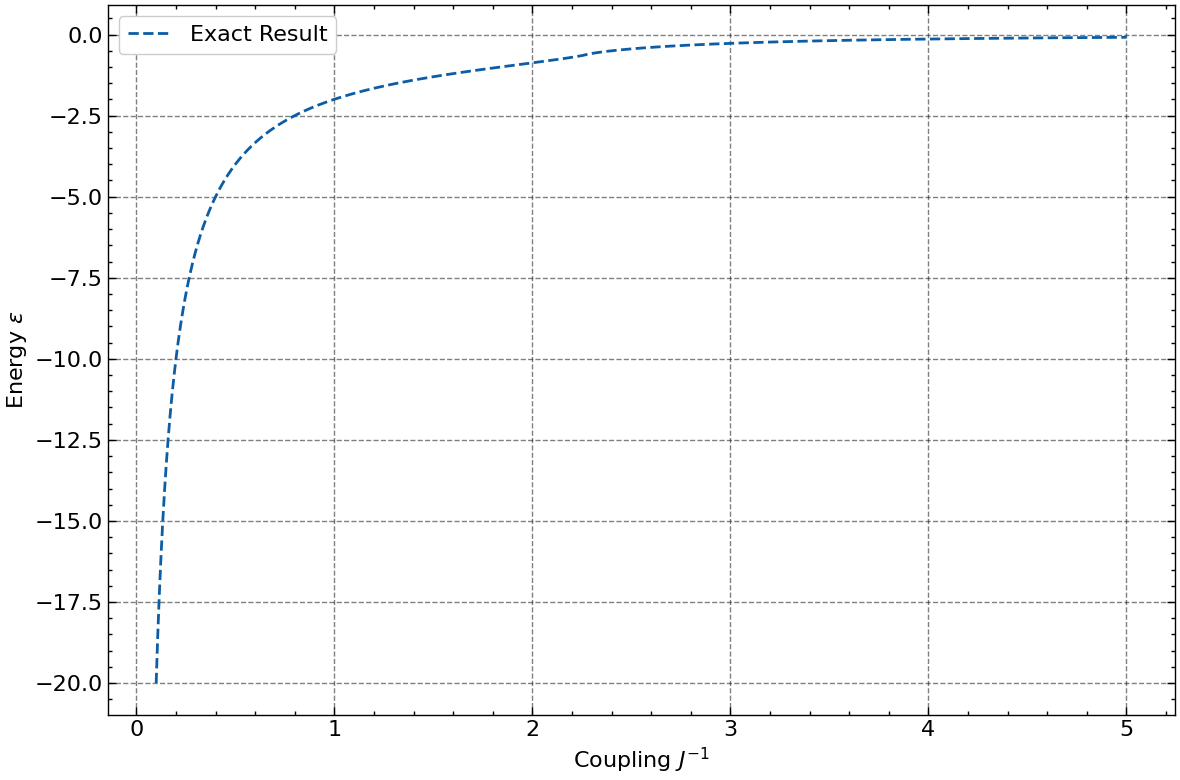

In [4]:
data = pd.read_csv('output/exact_results.csv')

fig, ax = plt.subplots()
ax.plot(1.0 / data['j'], data['energy'], '--', label='Exact Result')

ax.set_xlabel('Coupling $J^{-1}$')
ax.set_ylabel('Energy $\\epsilon$')

ax.legend()
fig.tight_layout()

## 5.2 MCMC for the 2D Ising Model

<font color='blue'> **Q. Implement a function which, given $J$ and a configuration of spins $\sigma$ on the 2D square lattice with periodic boundary conditions, computes $H$.**</font>

The functions are implemented in the common library: `../common/src/lattice.cpp` and `../common/src/lattice_2d.cpp`.

- **Magnetization**: Sum over all lattice sites.
- **Energy**: Sum of all lattice bonds (neighbouring spins) but count each bond only once.

<font color='blue'> **Q. Implement a function which, given $J$, a configuration $\sigma$, and a location $\vec{x}$, computes $\Delta H$.**</font>

Implemented in `../common/src/lattice.cpp` and `../common/src/lattice_2d.cpp`. Only computes the direct neighbours of the flipped spin to calculate difference.

<font color='blue'> **Q. Implement the Metropolis-Hastings for sampling from the 2D Ising model, using sweeps of single spin flips.**</font>

Implementation in `../common/src/lattice.cpp` for all classes which implement the lattice interface. 

<font color='blue'> **Q. Generate a single ensemble of $10^5$ configurations for $J = 0.5$ for each $N \in \{4, 8, 12\}$. On $3$ separate plots show the Monte Carlo histories of $m$, $|m|$, and $\epsilon$.**</font>

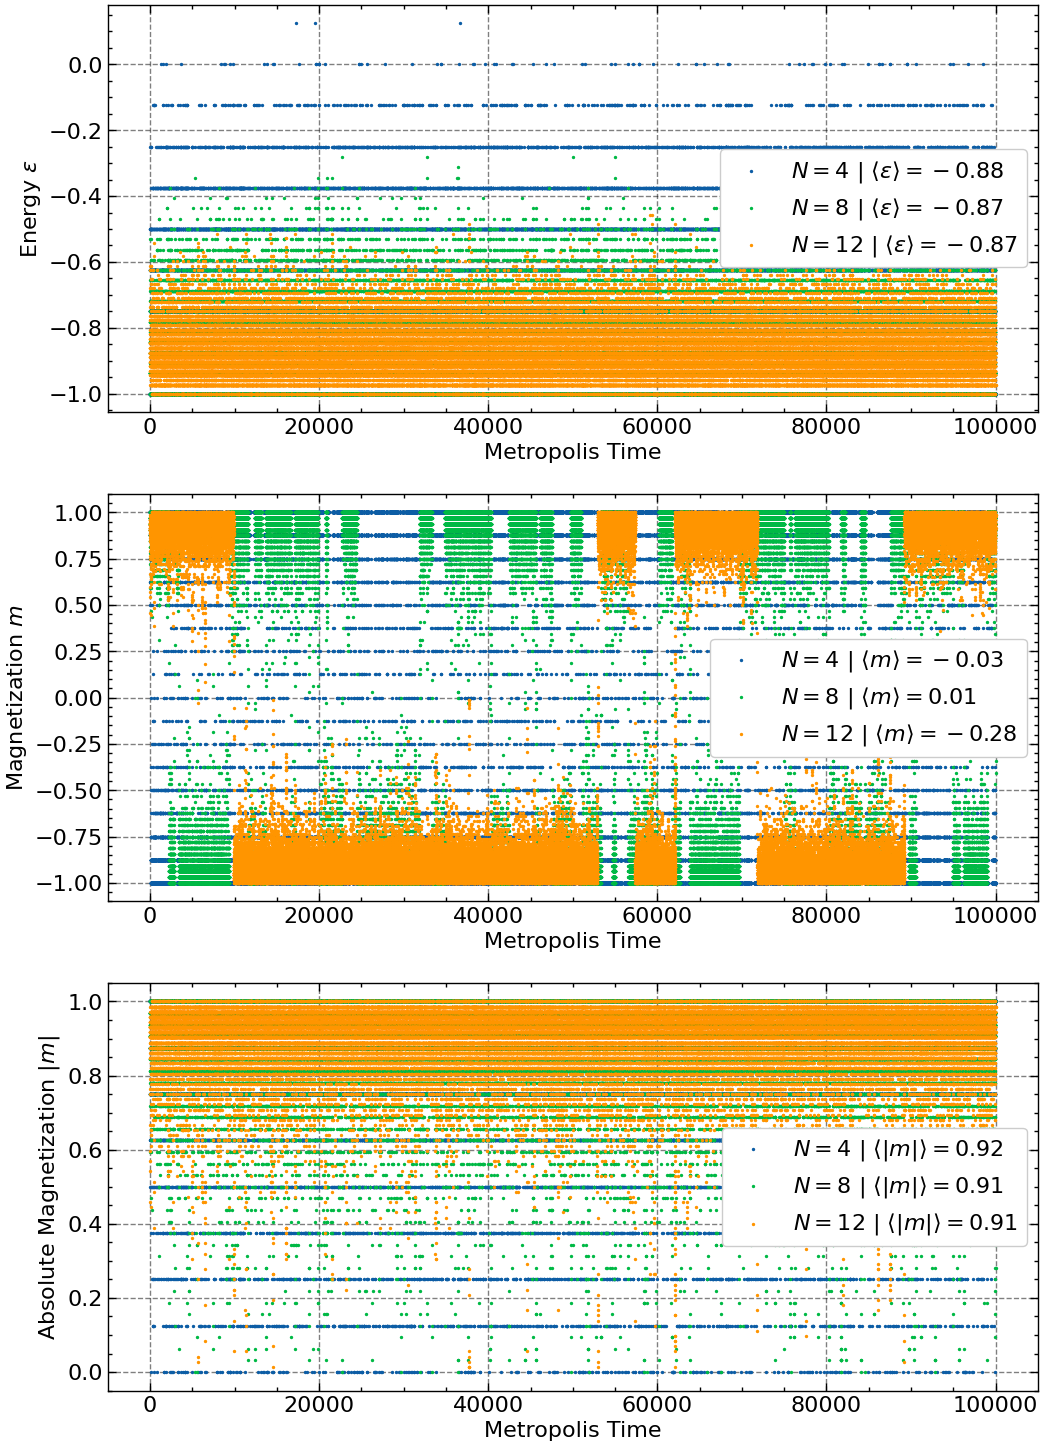

In [5]:
fig, ax = plt.subplots(3, 1, figsize=(12, 18))

for idx, length in enumerate(LATTICE_LENGTHS):
    data = pd.read_csv(f'output/history_{length}.csv')

    ax[0].scatter(data['sweeps'], data['energy'], s=2, label=f'$N = {length}$ | $\\langle \\epsilon \\rangle = {data['energy'].mean():.2f}$')
    ax[0].set_xlabel('Metropolis Time')
    ax[0].set_ylabel('Energy $\\epsilon$')

    ax[1].scatter(data['sweeps'], data['magnetization'], s=2, label=f'$N = {length}$ | $\\langle m \\rangle = {data['magnetization'].mean():.2f}$')
    ax[1].set_xlabel('Metropolis Time')
    ax[1].set_ylabel('Magnetization $m$')

    ax[2].scatter(data['sweeps'], np.abs(data['magnetization']), s=2, label=f'$N = {length}$ | $\\langle |m| \\rangle = {np.abs(data['magnetization']).mean():.2f}$')
    ax[2].set_xlabel('Metropolis Time')
    ax[2].set_ylabel('Absolute Magnetization $|m|$')

ax[0].legend(loc='center right')
ax[1].legend(loc='center right')
ax[2].legend(loc='center right')


<font color='blue'> **Q. Remember that as $0.5 = J > J_c \approx 0.44$ we are in the broken phase. How does that related to what you see in the Monte Carlo histories? Keep in mind we proved in class that $\langle m \rangle = 0$ for any finite $N$. Does that jibe with what you see?**</font>

In the broken phase both states of spontanous magnetization (all $+1$ or all $-1$) are equally likely. So the ensambles switch between these states constantly which results in $\langle m \rangle = 0$. The bigger the lattice is the longer it stays in one state of spontanous magnetization (See ensamble for $N=12$).

# 5.3 Slow Tunneling Means Long Autocorrelation Times

In [6]:
def normalized_autocorrelation_function(data: pd.Series):
    series = data - data.mean()
    fft = np.fft.fft(series, n=2*len(series))

    correlation = np.fft.ifft(fft * np.conjugate(fft))[:len(series)].real
    return correlation / correlation[0]

def calculate_tau(gammas: pd.Series):
    return 0.5 + gammas[1:np.where(gammas <= 0)[0][0]].sum()

<font color='blue'> **Q. Compute the autocorrelation time $\tau$ for $m$, $|m|$, and $\epsilon$ for the two test ensembles above. Do the results comport with the Monte Carlo history figure you made?**</font>

In the plots below you can see $\Gamma(T)$ plotted against the Monte Carlo time. The autocorrelation time $\tau$ can be seen in the legend and was calculated from the first point where $\Gamma(T)$ crossed the zero line. The values for computed in `python` using the data generated in the `c++` part from above.

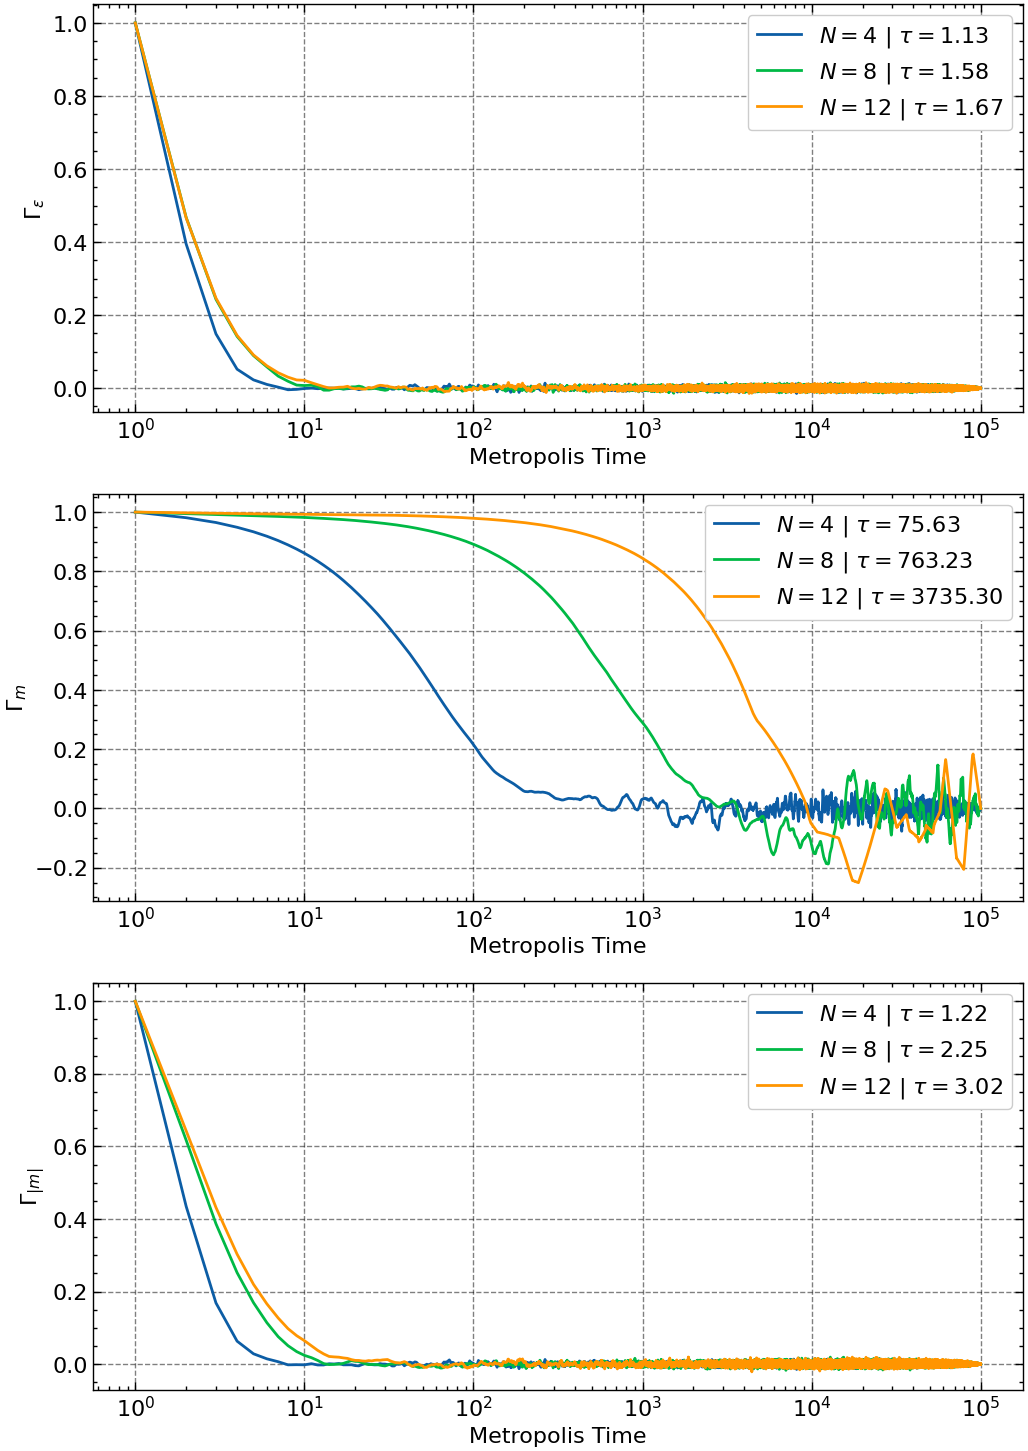

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(12, 18))

for idx, length in enumerate(LATTICE_LENGTHS):
    data = pd.read_csv(f'output/history_{length}.csv')

    gamma_e = normalized_autocorrelation_function(data['energy'])
    ax[0].plot(np.arange(1, len(gamma_e) + 1), gamma_e, '-', label=f'$N = {length}$ | $\\tau = {calculate_tau(gamma_e):.2f}$')

    gamma_m = normalized_autocorrelation_function(data['magnetization'])
    ax[1].plot(np.arange(1, len(gamma_m) + 1), normalized_autocorrelation_function(data['magnetization']), '-', label=f'$N = {length}$ | $\\tau = {calculate_tau(gamma_m):.2f}$')

    gamma_m_abs = normalized_autocorrelation_function(np.abs(data['magnetization']))
    ax[2].plot(np.arange(1, len(gamma_m_abs) + 1), normalized_autocorrelation_function(np.abs(data['magnetization'])), '-', label=f'$N = {length}$ | $\\tau = {calculate_tau(gamma_m_abs):.2f}$')


ax[0].set_xscale('log')
ax[0].set_xlabel('Metropolis Time')
ax[0].set_ylabel('$\\Gamma_\\epsilon$')
ax[0].legend(loc='upper right')

ax[1].set_xscale('log')
ax[1].set_xlabel('Metropolis Time')
ax[1].set_ylabel('$\\Gamma_m$')
ax[1].legend(loc='upper right')

ax[2].set_xscale('log')
ax[2].set_xlabel('Metropolis Time')
ax[2].set_ylabel('$\\Gamma_{|m|}$')
ax[2].legend(loc='upper right')

<font color='blue'> **Q. Recall that when $h = 0$ we have an extra $\mathbb{Z}_2$ symmetry: $\sigma$ and $-\sigma$ have the same weight, and this guarantees that $\langle m \rangle = 0$ for any finite $N$. Write $1$ or $2$ sentences explaining why the very slow autocorrelation time of $m$ is not important.**</font>

Because we are in the broken phase the ensamble flips often enough that even though the samples are still correlated, we get approximately $\langle m \rangle = 0$. This, at least, is true for small lattice sizes. For a bigger lattice (see $N=12$) we may need more Monte Carlo for this to be true.

# 5.4 The Thermodynamic Limit for One $J$

In [8]:
def thermalizing(data: pd.Series, tau: float):
    return data[3 * int(np.ceil(tau)):]

def blocking(data: pd.Series, tau: float):
    stride = int(np.ceil(tau));
    remainder = len(data) % stride
    
    return data[remainder:].to_numpy().reshape(-1, stride).mean(axis=-1)

def bootstrap_sampling(block: np.array, num_bootstrap_resamples = 5000) -> Tuple[float, float]:
    draws = np.random.choice(block, size=(num_bootstrap_resamples, len(block))).mean(axis=1)
    return draws.mean(), draws.std()

<font color='blue'> **Q. Perform a bootstrap analysis estimating the mean and uncertainty for $\langle |m| \rangle$ and $\langle \epsilon \rangle$ for each ensemble.**</font>

For the bootstrap analysis we discard the first $3\cdot \lceil \tau \rceil$ steps as thermalization. We then use $\lceil \tau \rceil$ to split the data into blocks for which we then calculate the mean. We then take $A=10^5$ samples from the blocks with replacement and calculate the mean over them. This we repeat $B=5000$ times and then take the mean and std of those means to get our bootstrap analysis. This was also done in python and quite slow compared to the Metropolis algorithm. In the future this should also be handled by the `c++` code.

In [9]:
res_mean_e = []
res_std_e = []

res_mean_m = []
res_std_m = []

res_mean_m_abs = []
res_std_m_abs = []

for idx, length in enumerate(LATTICE_LENGTHS):
    data = pd.read_csv(f'output/history_{length}.csv')

    # Calculate autocorrelation time
    tau_e = calculate_tau(normalized_autocorrelation_function(data['energy']))
    tau_m = calculate_tau(normalized_autocorrelation_function(data['magnetization']))
    tau_m_abs = calculate_tau(normalized_autocorrelation_function(np.abs(data['magnetization'])))
    tau = np.maximum(tau_e, tau_m_abs)

    # Bootstrap sampling for Energy
    blocks_e = blocking(thermalizing(data['energy'], tau), tau)
    mean_e, std_e = bootstrap_sampling(blocks_e)
    res_mean_e.append(mean_e)
    res_std_e.append(std_e)

    # Bootstrap sampling for Mangetization
    blocks_m = blocking(thermalizing(data['magnetization'], tau), tau)
    mean_m, std_m = bootstrap_sampling(blocks_m)
    res_mean_m.append(mean_m)
    res_std_m.append(std_m)

    # Bootstrap sampling for Absolute Mangetization
    blocks_m_abs = blocking(thermalizing(np.abs(data['magnetization']), tau), tau)
    mean_m_abs, std_m_abs = bootstrap_sampling(blocks_m_abs)
    res_mean_m_abs.append(mean_m_abs)
    res_std_m_abs.append(std_m_abs)

    print(f'################## N = {length} ##################')
    print(f'Autocorrelation times:')
    print(f'\t Energy:                 {tau_e:.2f}')
    print(f'\t Magnetization:          {tau_m:.2f}')
    print(f'\t Absolute Magnetization: {tau_m_abs:.2f}')
    print(f'Bootstrap analysis with tau = {tau:.2f}:')
    print(f'\t Energy:                 ({mean_e:.4f} +- {std_e:.4f})')
    print(f'\t Magnetization:          ({mean_m:.4f} +- {std_m:.4f})')
    print(f'\t Absolute Magnetization: ({mean_m_abs:.4f} +- {std_m_abs:.4f})')

################## N = 4 ##################
Autocorrelation times:
	 Energy:                 1.13
	 Magnetization:          75.63
	 Absolute Magnetization: 1.22
Bootstrap analysis with tau = 1.22:
	 Energy:                 (-0.8779 +- 0.0007)
	 Magnetization:          (-0.0254 +- 0.0042)
	 Absolute Magnetization: (0.9191 +- 0.0006)
################## N = 8 ##################
Autocorrelation times:
	 Energy:                 1.58
	 Magnetization:          763.23
	 Absolute Magnetization: 2.25
Bootstrap analysis with tau = 2.25:
	 Energy:                 (-0.8725 +- 0.0005)
	 Magnetization:          (0.0094 +- 0.0050)
	 Absolute Magnetization: (0.9110 +- 0.0005)
################## N = 12 ##################
Autocorrelation times:
	 Energy:                 1.67
	 Magnetization:          3735.30
	 Absolute Magnetization: 3.02
Bootstrap analysis with tau = 3.02:
	 Energy:                 (-0.8725 +- 0.0003)
	 Magnetization:          (-0.2757 +- 0.0055)
	 Absolute Magnetization: (0.9109 +- 0.0

<font color='blue'> **Q. For both observables plot the estimates (with uncertainties as error bars) against $1/N^2$ (so the thermodyanmic limit is at 0). Show the known exact results given above at $1/N^2$.**</font>

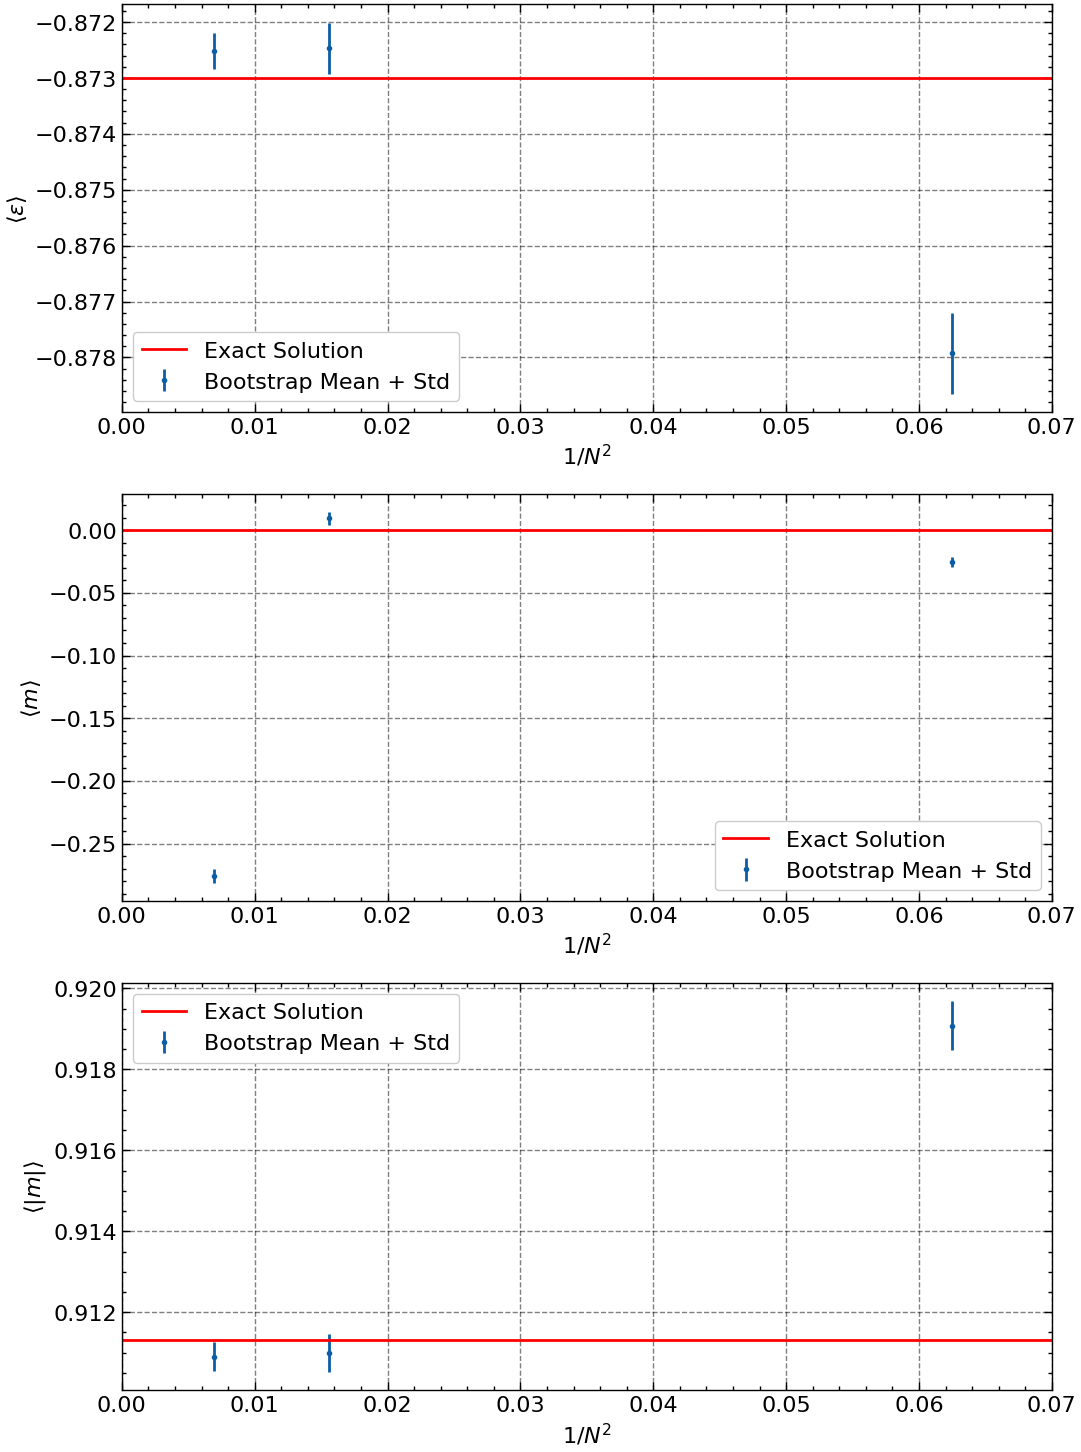

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(12, 18))

ax[0].errorbar(1.0 / LATTICE_LENGTHS**2, res_mean_e, yerr=res_std_e, label='Bootstrap Mean + Std')
ax[0].axhline(-0.873, color='red', label='Exact Solution')
ax[0].set_xlim([0, 0.07])
ax[0].set_xlabel('$1/N^2$')
ax[0].set_ylabel('$\\langle \\epsilon \\rangle$')
ax[0].legend()

ax[1].errorbar(1.0 / LATTICE_LENGTHS**2, res_mean_m, yerr=res_std_m, label='Bootstrap Mean + Std')
ax[1].axhline(0, color='red', label='Exact Solution')
ax[1].set_xlim([0, 0.07])
ax[1].set_xlabel('$1/N^2$')
ax[1].set_ylabel('$\\langle m \\rangle$')
ax[1].legend()

ax[2].errorbar(1.0 / LATTICE_LENGTHS**2, res_mean_m_abs, yerr=res_std_m_abs, label='Bootstrap Mean + Std')
ax[2].axhline(0.9113194, color='red', label='Exact Solution')
ax[2].set_xlim([0, 0.07])
ax[2].set_xlabel('$1/N^2$')
ax[2].set_ylabel('$\\langle |m| \\rangle$')
ax[2].legend()

<font color='blue'> **Q. Explain what you see in a few sentences.**</font>

We can see that for larger $1/N^2 \rightarrow 0$ our observable approach the thermodynamic limit. This works well for $\langle \epsilon \rangle$ and $\langle |m| \rangle$ but not for $\langle m \rangle$. This is because we use too short autocorrelation time which means that the blocked samples are not independent. At $N=12$ there is also not enough time for the ensamble to flip often enough for it approach $\langle m \rangle = 0$ by itself.